In [31]:
import pandas as pd
import polars as pl
import numpy as np
import pickle, warnings, datetime, gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
warnings.filterwarnings('ignore')

In [32]:
with open('../../data/processed/gdelt_intermediate_cleaned.pkl', 'rb') as f:
    df = pickle.load(f)

We perform PCA on 3 subsets of the data:
1. The 7 GKG1 columns: Tone, Positive Score, Negative Score, Polarity, Activity Reference Density, Self/Group Reference Density, Word Count
2. The 2410 GKG2 columns that use word count
3. The 40 GKG2 columns that use a scored value

In [33]:
columns_to_drop = [
        'V2SOURCECOMMONNAME',
        'V2DOCUMENTIDENTIFIER',
        'V1THEMES',
        'datetime',
        'date',
        'airplane',
        'airline',
        'airport',
        'Alaska Airlines',
        'American Airlines',
        'Delta Air Lines',
        'Frontier Airlines',
        'Hawaiian Airlines',
        'JetBlue',
        'Southwest Airlines',
        'Spirit Airlines',
        'Sun Country Airlines',
        'United Airlines',
        'Allegiant Air',
        'article_title']

df = df.drop(columns_to_drop)

In [34]:
# Preprocessing
# Inner join records_to_keep to df
df.index = df['GKGRECORDID']
df = df.drop('GKGRECORDID')

In [ ]:
# Sample the data to reduce size
sample_size = 400000 # Increase this if you have more memory. This is my limit with 48GB RAM
df = df.sample(n=sample_size, seed=1234)

In [36]:
# Split into the three subsets
df_1 = df.select(['Tone',
 'Positive Score',
 'Negative Score',
 'Polarity',
 'Activity Reference Density',
 'Self/Group Reference Density',
 'Word Count'])

df_2 = df.select(pl.selectors.contains('WORDCOUNT'))
df_3 = df.select(pl.selectors.contains('SCOREDVALUE'))

In [37]:
# Rescale the datasets
scaler = StandardScaler()
df_1 = scaler.fit_transform(df_1)
df_2 = scaler.fit_transform(df_2)
df_3 = scaler.fit_transform(df_3)

In [38]:
df_1

array([[ 0.06406967,  0.22477587,  0.06383049, ..., -0.698371  ,
        -0.88226071, -0.09407066],
       [ 0.76393005,  0.15470478, -0.95093295, ...,  1.19261362,
        -0.88226071, -0.25127604],
       [ 0.71690982,  1.3905272 , -0.04816054, ...,  0.43466073,
        -0.52782955, -0.08079738],
       ...,
       [ 0.31055012, -0.02316697, -0.44490947, ..., -0.3295105 ,
        -0.49805067,  0.019167  ],
       [ 0.79854425,  0.36640937, -0.85525397, ...,  0.41501639,
         4.01728097,  0.06811221],
       [ 0.12477239,  0.5208798 ,  0.18066896, ..., -0.26646457,
         1.24526975,  0.09922145]])

In [39]:
df_1.shape

(400000, 7)

In [40]:
df_2

array([[ 0.29590503, -0.25941257, -0.21837461, ...,  0.04253944,
         0.02861124, -0.18584949],
       [-0.1592722 , -0.12105329,  0.17914716, ..., -0.24717958,
        -0.22605651, -0.13238117],
       [-0.1592722 , -0.25941257, -0.21837461, ...,  0.04253944,
        -0.07325586, -0.01059222],
       ...,
       [-0.1592722 ,  0.01730598, -0.21837461, ..., -0.24717958,
        -0.05627801,  0.05772841],
       [-0.1592722 , -0.12105329,  0.17914716, ..., -0.24717958,
        -0.06476693, -0.18584949],
       [ 1.20625948, -0.12105329,  0.17914716, ..., -0.24717958,
         0.02861124,  0.23001522]])

In [41]:
df_2.shape

(400000, 2410)

In [42]:
df_3

array([[ 0.05861745,  0.88872017, -0.41746352, ...,  0.22727805,
         0.3665242 ,  0.58819849],
       [-0.15923754,  0.37698583,  0.91733516, ..., -0.97813156,
        -1.47414524, -1.78438888],
       [-0.35473471,  0.03873098,  0.18481758, ...,  0.23991214,
        -0.49556329, -1.09086305],
       ...,
       [-0.2173808 , -0.81174603,  1.51701861, ..., -0.2895583 ,
        -0.04741223, -0.77110384],
       [ 0.75316611, -1.14724882,  0.98189158, ...,  0.22727805,
         0.3665242 ,  0.58819849],
       [ 0.45110908,  0.07741747,  0.43984658, ..., -0.50704968,
        -1.52957921, -1.00784159]])

In [43]:
df_3.shape

(400000, 40)

In [44]:
# Perform PCA
pca_fit_1 = PCA().fit(df_1)
pca_fit_1.explained_variance_ratio_

array([3.75119664e-01, 2.20189022e-01, 1.53354560e-01, 1.41973894e-01,
       1.09362859e-01, 6.36430272e-16, 1.72444431e-16])

In [45]:
pca_fit_1.components_

# Write this to a pickle file
with open(r'../../data/processed/pca_fit_1.pkl', 'wb') as f:
    pickle.dump(pca_fit_1, f)

In [39]:
pca_fit_2 = PCA().fit(df_2)
pca_fit_2.explained_variance_ratio_

array([6.51179197e-01, 1.96484046e-02, 1.16429800e-02, ...,
       3.98765869e-33, 3.98765869e-33, 8.72003906e-35])

In [40]:
pca_fit_3 = PCA().fit(df_3)
pca_fit_3.explained_variance_ratio_

array([2.28522071e-01, 1.51669817e-01, 1.41536987e-01, 9.56499941e-02,
       7.73427500e-02, 3.99514492e-02, 3.48840925e-02, 2.82235403e-02,
       2.74554447e-02, 2.33660425e-02, 2.07783686e-02, 1.61992441e-02,
       1.57554662e-02, 1.04783396e-02, 9.67046581e-03, 9.52205689e-03,
       8.35415302e-03, 7.11553584e-03, 6.79364687e-03, 5.21110102e-03,
       4.75168206e-03, 4.22714226e-03, 4.04791824e-03, 3.93998831e-03,
       3.92296807e-03, 3.75879318e-03, 3.32749062e-03, 3.10424014e-03,
       2.35241855e-03, 2.27857547e-03, 2.08979672e-03, 1.36083574e-03,
       9.74964435e-04, 4.64209245e-04, 3.69331744e-04, 2.70252659e-04,
       1.81216140e-04, 5.07310369e-05, 3.91454172e-05, 7.73340500e-06])

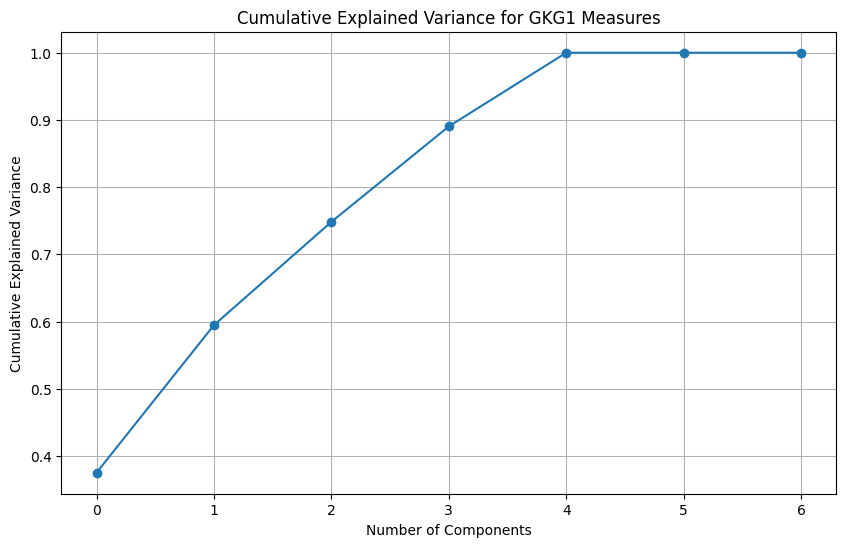

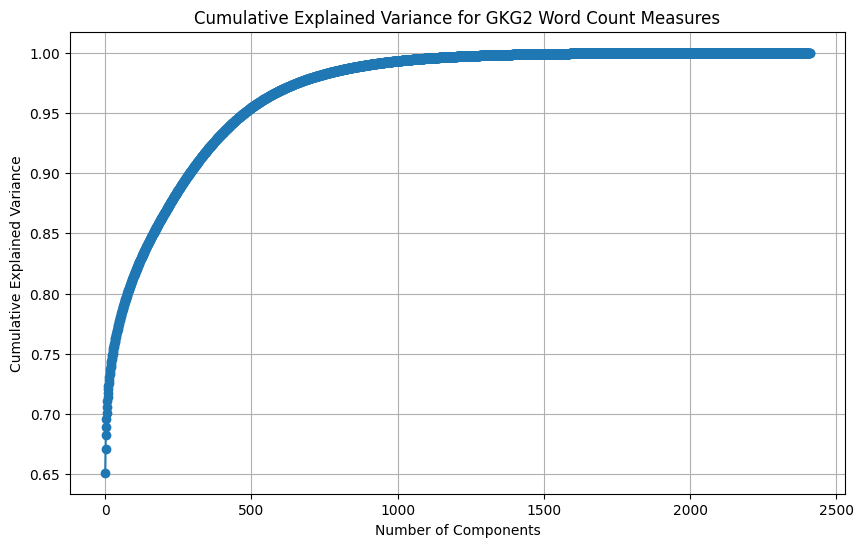

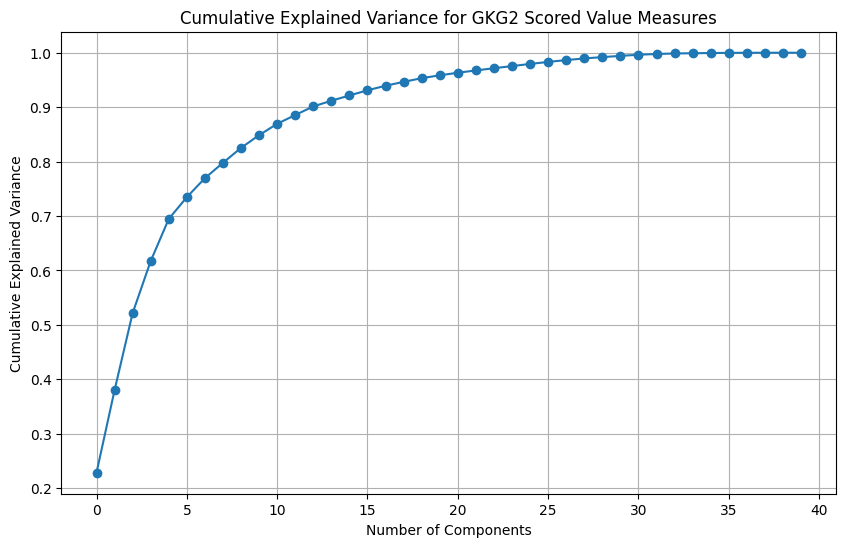

In [42]:
# Make cumulative explained variance plots for each PCA fit
def plot_cumulative_explained_variance(pca_fit, title):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca_fit.explained_variance_ratio_), marker='o')
    plt.title(title)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
plot_cumulative_explained_variance(pca_fit_1, 'Cumulative Explained Variance for GKG1 Measures')
plot_cumulative_explained_variance(pca_fit_2, 'Cumulative Explained Variance for GKG2 Word Count Measures')
plot_cumulative_explained_variance(pca_fit_3, 'Cumulative Explained Variance for GKG2 Scored Value Measures')